DataFrame contains NaN values: False


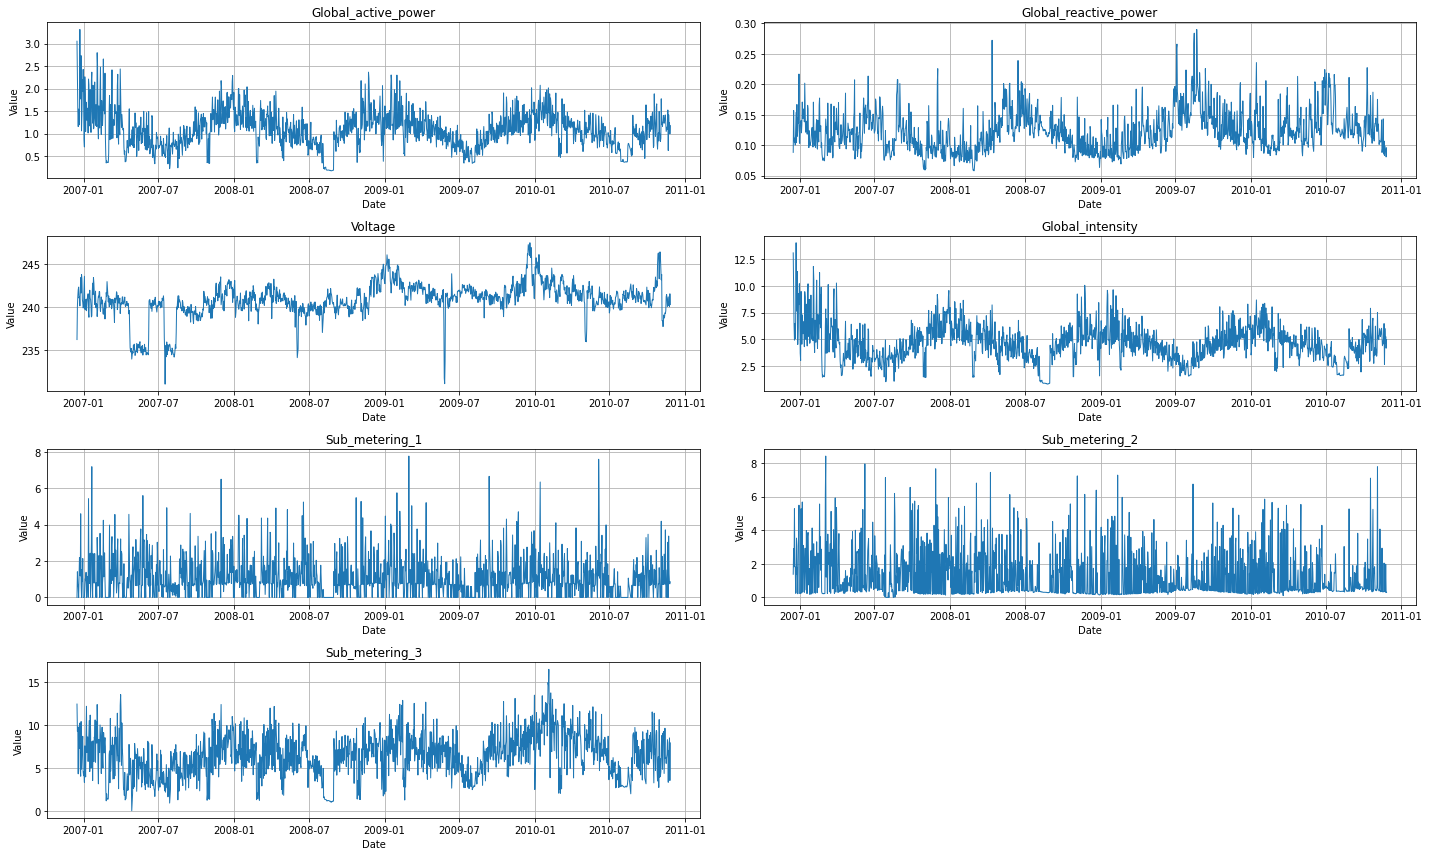

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
torch.manual_seed(123)

dataset_file = 'household_power_consumption.txt'
data = pd.read_csv(dataset_file, sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')
data=data.dropna()
# Resample the data to have one value per day
daily_data = data.resample('D').mean()
daily_data = daily_data.dropna()
has_nans = daily_data.isna().any().any()

print(f"DataFrame contains NaN values: {has_nans}")
# Plot each time series
plt.figure(figsize=(20, 12))
for i, col in enumerate(daily_data.columns):
    plt.subplot(4, 2, i+1)
    plt.plot(daily_data.index, daily_data[col],linewidth=1)
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
time_series = daily_data.values
ts_train = time_series[:1000]
ts_test = time_series[1000:]
scaler = StandardScaler()
scaler.fit(ts_train)
print(time_series.shape)

(1433, 7)


In [3]:
y_train = torch.from_numpy(ts_train[12:]).float()
y_test = torch.from_numpy(ts_test[12:]).float()
x_train = torch.from_numpy(scaler.transform(ts_train[:-3])).float()
x_test = torch.from_numpy(scaler.transform(ts_test[:-3])).float()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([997, 7])
torch.Size([988, 7])
torch.Size([430, 7])
torch.Size([421, 7])


In [4]:
x_train = x_train.unfold(0, 10, 1).unsqueeze(2).reshape(-1, 10, 7)
x_test = x_test.unfold(0, 10, 1).unsqueeze(2).reshape(-1, 10, 7)
y_train = y_train.reshape(-1, 7)
y_test = y_test.reshape(-1, 7)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


torch.Size([988, 10, 7])
torch.Size([988, 7])
torch.Size([421, 10, 7])
torch.Size([421, 7])


In [5]:
import torch.nn as nn
from torch.nn import functional as F

class ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout_fn,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):
   
        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout_fn = dropout_fn
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = nn.utils.weight_norm(
                self.conv1
            ), nn.utils.weight_norm(self.conv2)

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        # first step
        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout_fn(F.relu(self.conv1(x)))

        # second step
        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout_fn(x)

        # add residual
        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x

class TCNModule(nn.Module):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: int,
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        dropout: float,
    ):

        super().__init__()

        # Defining parameters
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base
        self.dropout = nn.Dropout(p=dropout)

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = ResidualBlock(
                num_filters,
                kernel_size,
                dilation_base,
                self.dropout,
                weight_norm,
                i,
                num_layers,
                self.input_size,
                target_size * nr_params,
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    def forward(self, x_in):
        x = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, -1, self.target_size, self.nr_params
        )

        return x

In [6]:
# Define the TCN model
input_size = 7
kernel_size = 3
num_filters = 32
num_layers = 4
dilation_base = 2
weight_norm = False
target_size = 7
nr_params = 1
dropout = 0.2

tcn_model = TCNModule(
    input_size, kernel_size, num_filters, num_layers, dilation_base,
    weight_norm, target_size, nr_params, dropout
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = tcn_model(x_train)
    y_true = y_train.unsqueeze(2) 
    loss = criterion(outputs[:, -1, :, :], y_true)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# Generate predictions for t+3
with torch.no_grad():
    predictions = tcn_model(x_test)
    print(predictions.shape)
    predicted = predictions[:, -1, :, :]# Extract the predicted values at t+3
    print(predicted.shape)

Epoch [100/10000], Loss: 131.0617
Epoch [200/10000], Loss: 53.3158
Epoch [300/10000], Loss: 28.8542
Epoch [400/10000], Loss: 22.2901
Epoch [500/10000], Loss: 16.8084
Epoch [600/10000], Loss: 14.0250
Epoch [700/10000], Loss: 12.0674
Epoch [800/10000], Loss: 13.5881
Epoch [900/10000], Loss: 9.4880
Epoch [1000/10000], Loss: 12.4275
Epoch [1100/10000], Loss: 8.4886
Epoch [1200/10000], Loss: 8.2447
Epoch [1300/10000], Loss: 7.8619
Epoch [1400/10000], Loss: 6.9409
Epoch [1500/10000], Loss: 5.9457
Epoch [1600/10000], Loss: 6.7843
Epoch [1700/10000], Loss: 5.6878
Epoch [1800/10000], Loss: 6.1247
Epoch [1900/10000], Loss: 5.8316
Epoch [2000/10000], Loss: 5.1095
Epoch [2100/10000], Loss: 4.6529
Epoch [2200/10000], Loss: 5.8005
Epoch [2300/10000], Loss: 4.6226
Epoch [2400/10000], Loss: 4.4520
Epoch [2500/10000], Loss: 3.8086
Epoch [2600/10000], Loss: 3.6561
Epoch [2700/10000], Loss: 4.0417
Epoch [2800/10000], Loss: 3.7045
Epoch [2900/10000], Loss: 3.8743
Epoch [3000/10000], Loss: 3.6910
Epoch [31

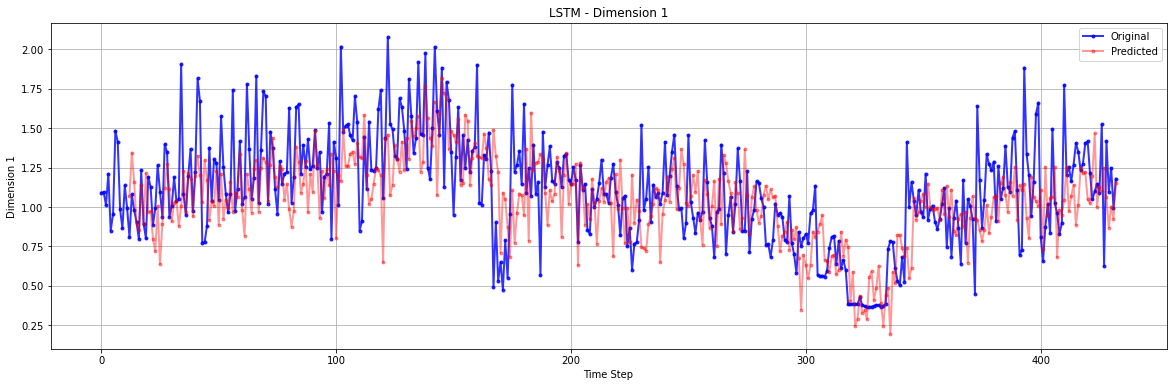

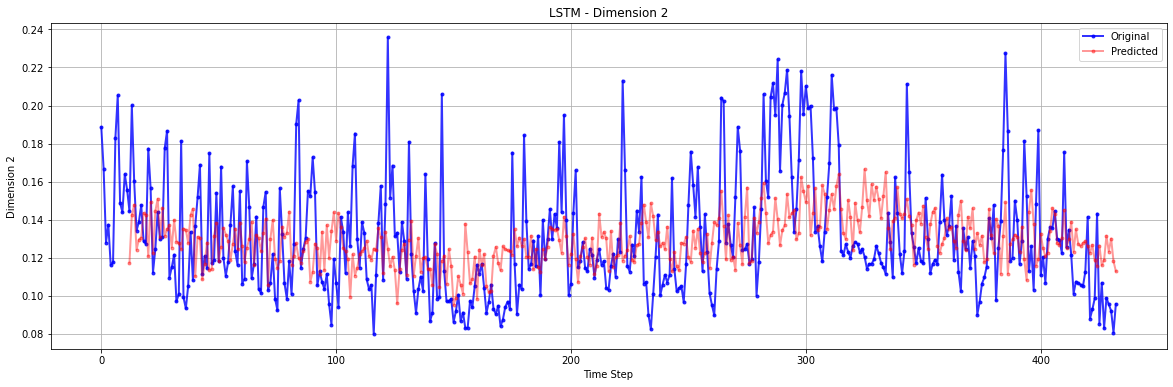

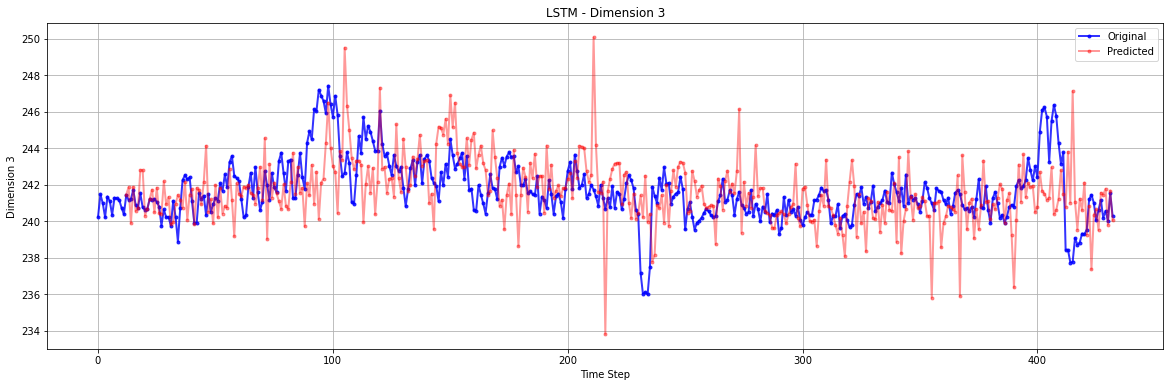

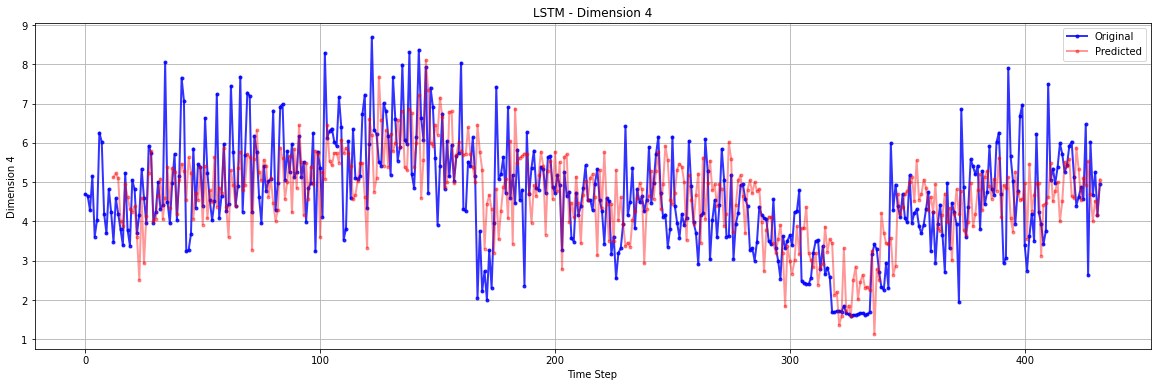

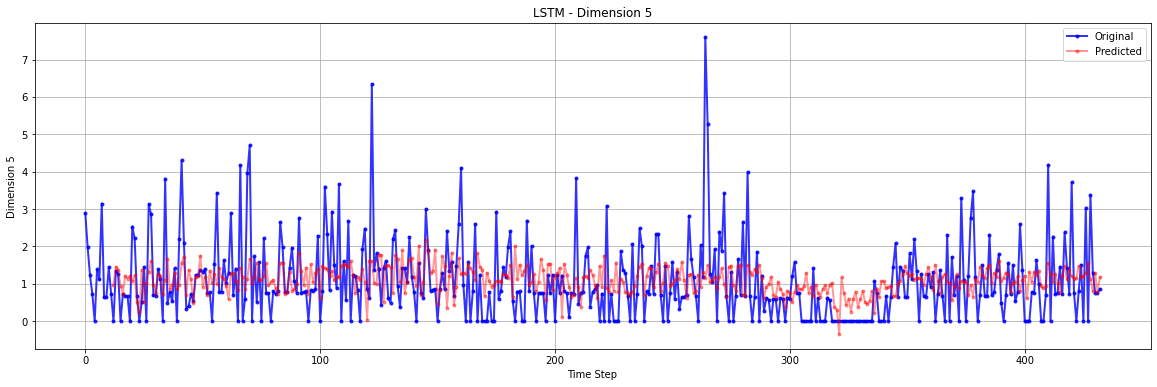

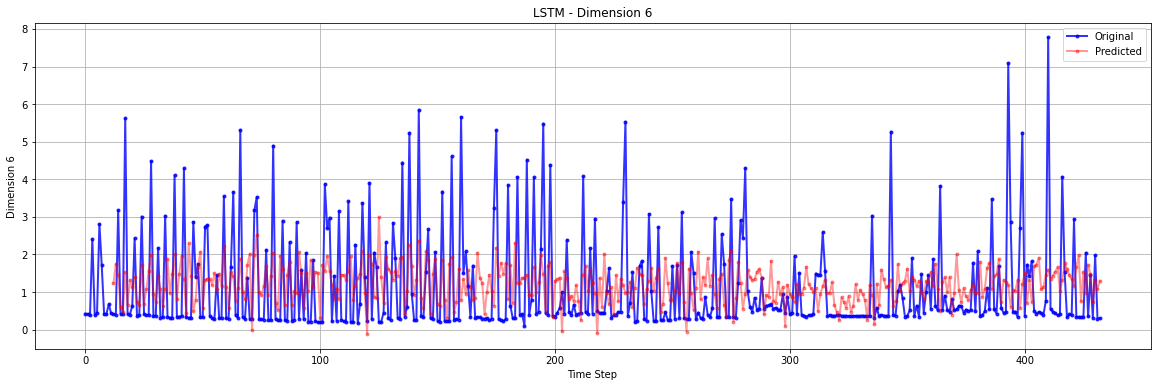

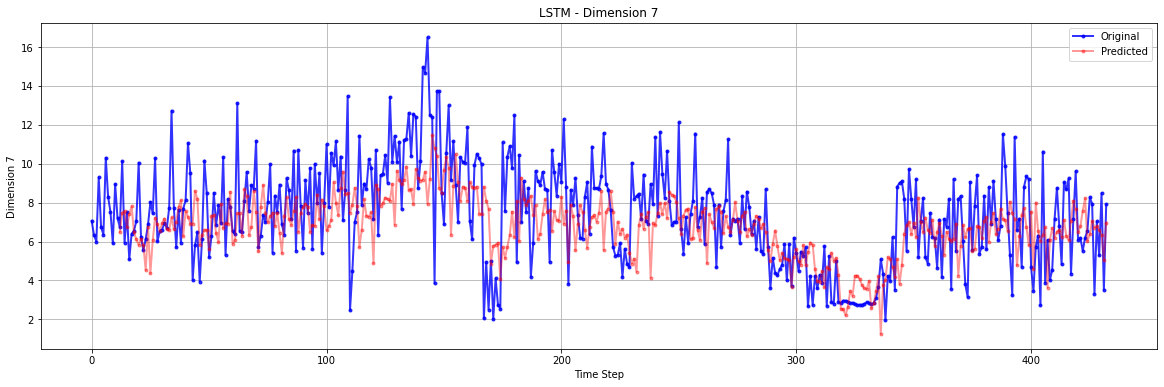

In [7]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,marker='.',alpha=0.8)
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=0.4,marker='.')
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'LSTM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Calculate MSE
mse = torch.mean((predicted.squeeze() - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(predicted.squeeze() - y_test),dim=0)
print('Metrics for Original Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

Metrics for Original Prediction
Dimension 1:
MSE: 0.0847
MAE: 0.2260

Dimension 2:
MSE: 0.0009
MAE: 0.0234

Dimension 3:
MSE: 4.3153
MAE: 1.5229

Dimension 4:
MSE: 1.4607
MAE: 0.9521

Dimension 5:
MSE: 1.0475
MAE: 0.7527

Dimension 6:
MSE: 1.7200
MAE: 0.9949

Dimension 7:
MSE: 5.4594
MAE: 1.8378



In [9]:
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data

x_test.requires_grad = True
outputs = tcn_model(x_test)        
loss = criterion(outputs[:, -1, :, :], y_test.unsqueeze(2))
loss.backward(retain_graph=True)
data_grad = x_test.grad.data

In [10]:
perturbed_data = fgsm_attack(x_test, 0.2, data_grad)
perturbed_data = perturbed_data
perturbed_predicted = tcn_model(perturbed_data).detach().numpy()
perturbed_predicted=perturbed_predicted[:, -1, :, :]
print(perturbed_predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted).squeeze() - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted).squeeze() - y_test),dim=0)
print('Metrics for on_FGSM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

(421, 7, 1)
Metrics for on_FGSM Prediction
Dimension 1:
MSE: 0.1368
MAE: 0.2917

Dimension 2:
MSE: 0.0010
MAE: 0.0239

Dimension 3:
MSE: 6.0549
MAE: 1.7900

Dimension 4:
MSE: 2.3417
MAE: 1.2267

Dimension 5:
MSE: 1.1775
MAE: 0.8104

Dimension 6:
MSE: 2.2780
MAE: 1.1249

Dimension 7:
MSE: 7.6133
MAE: 2.2389



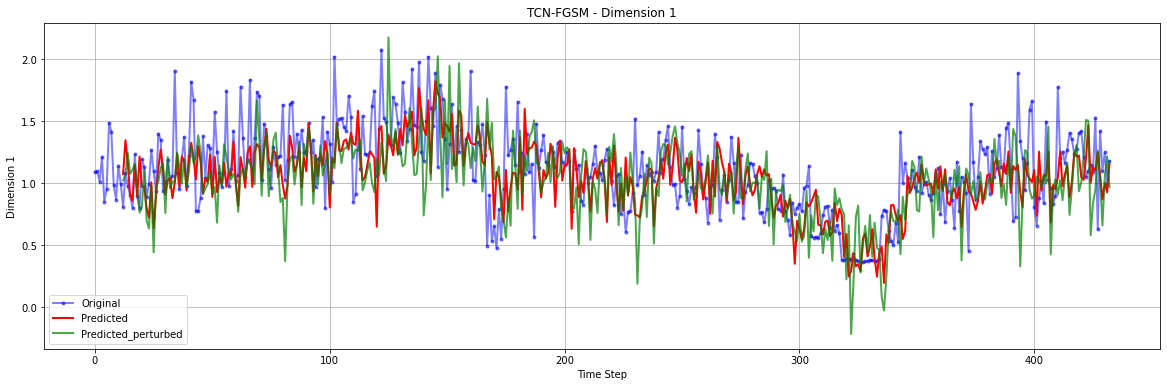

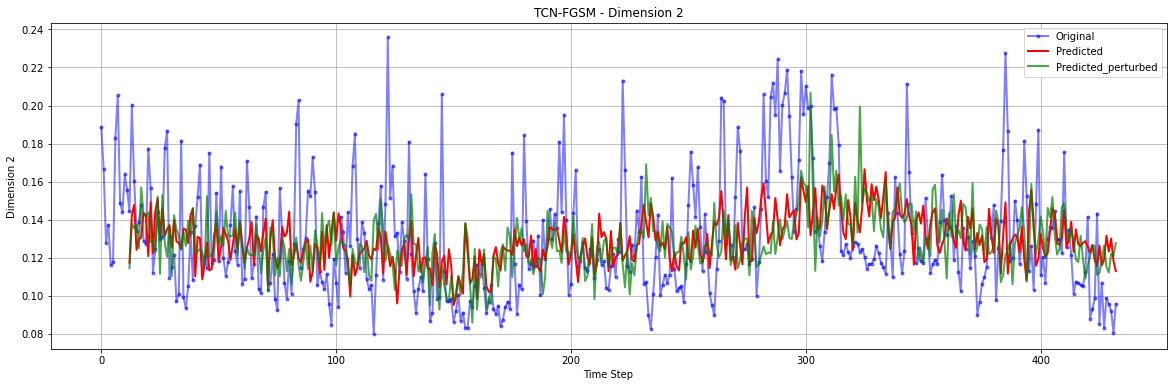

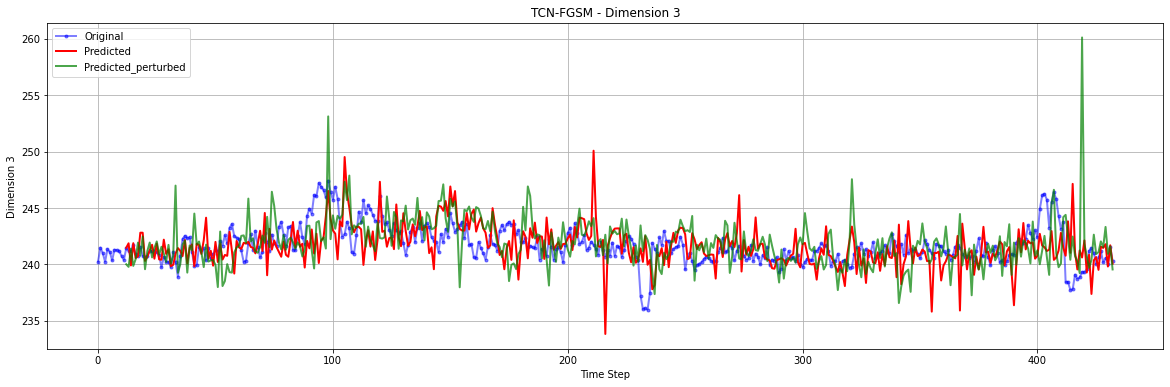

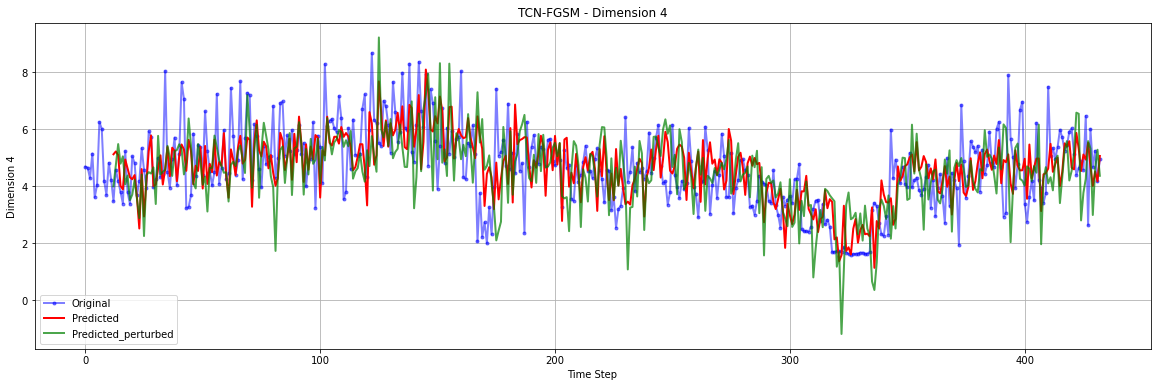

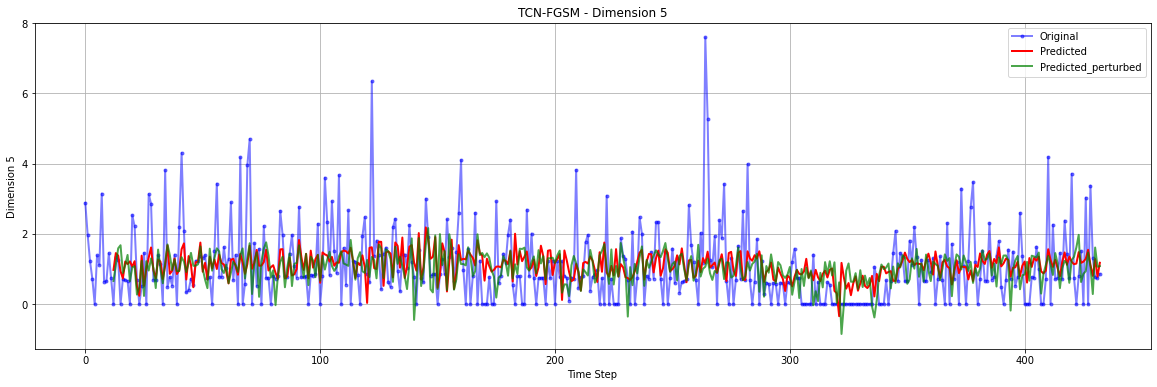

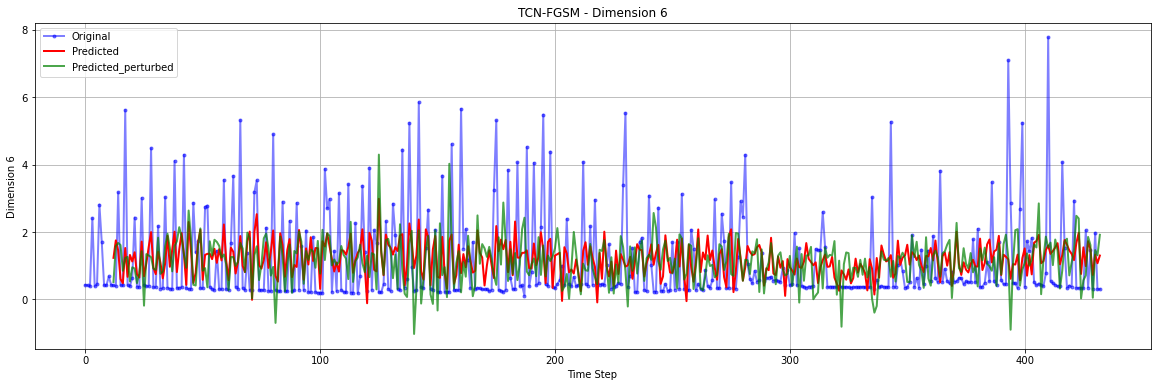

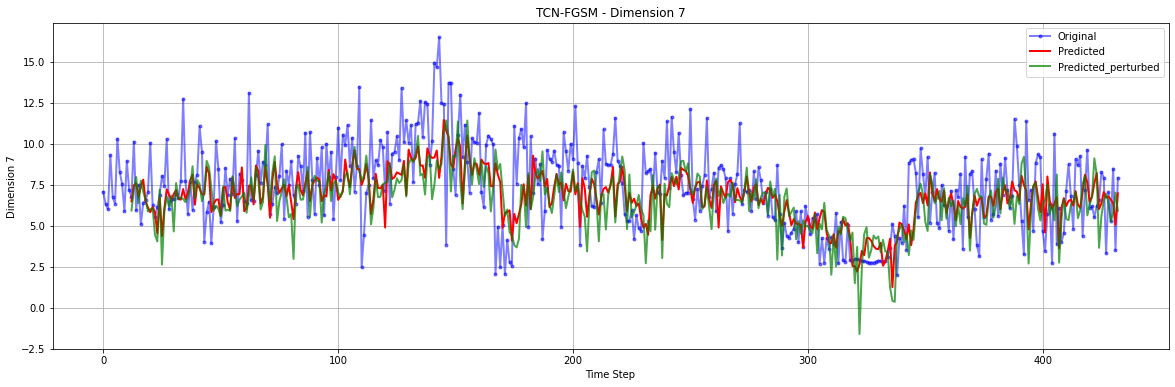

In [11]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'TCN-FGSM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

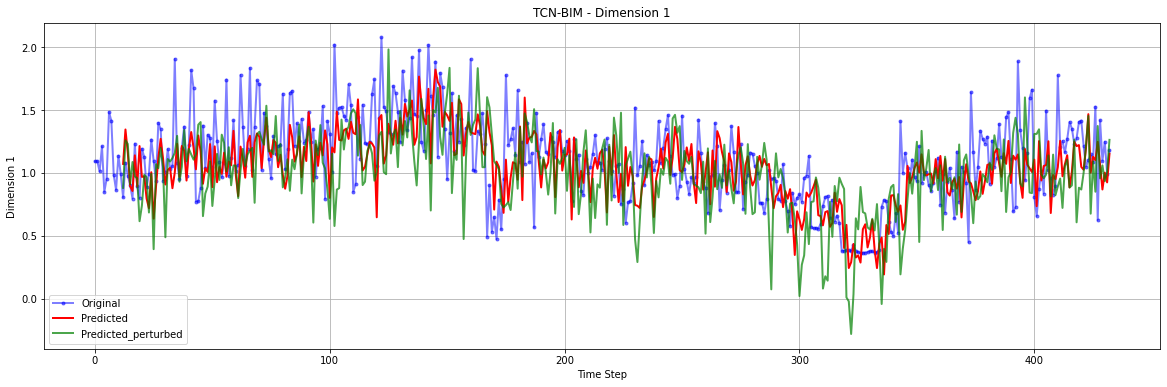

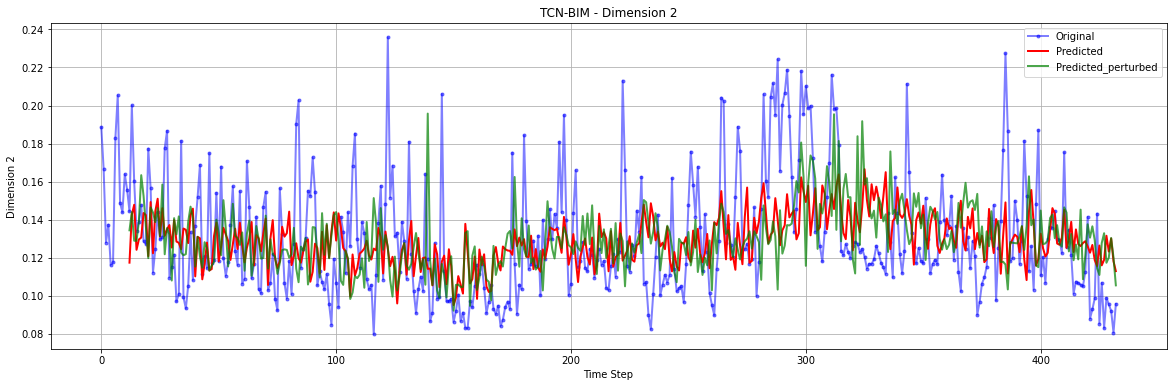

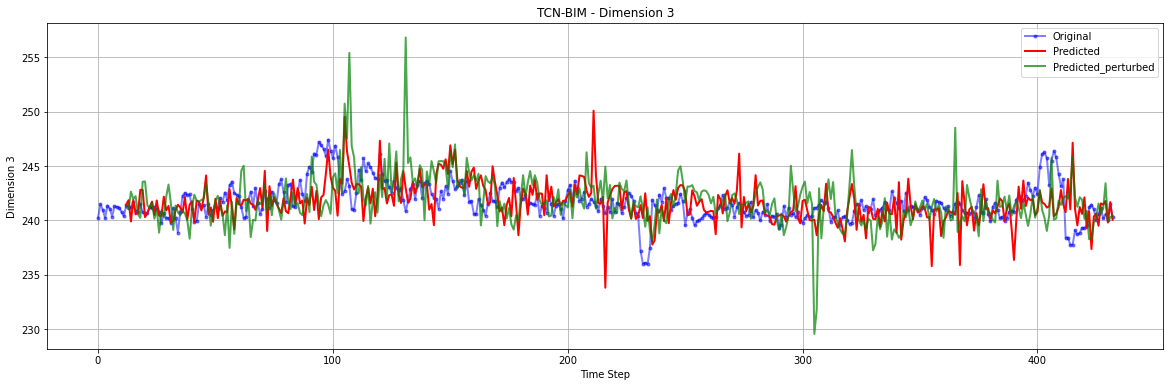

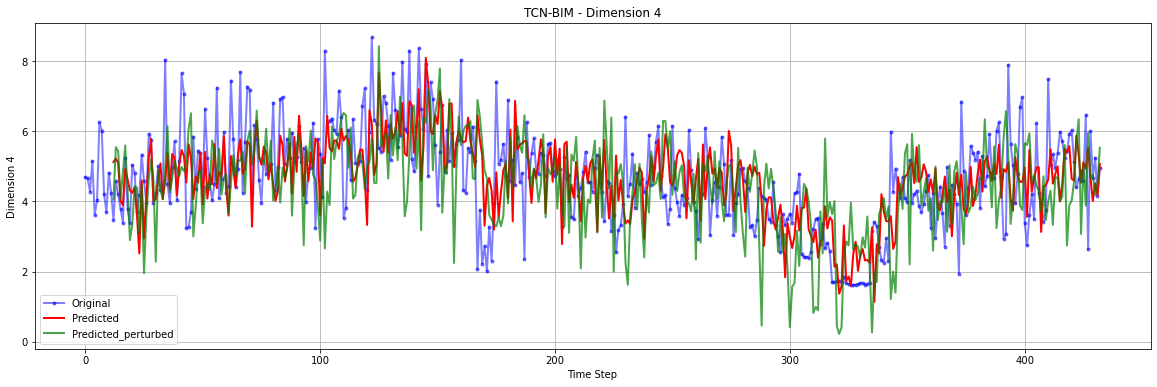

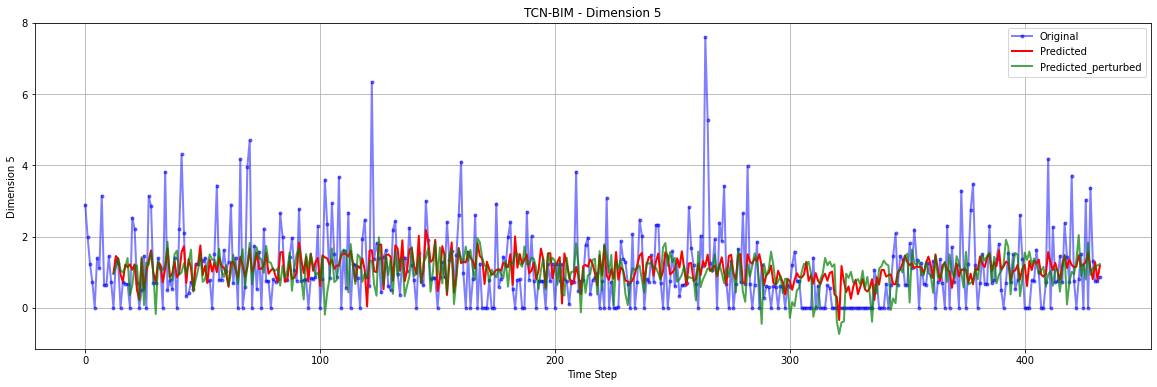

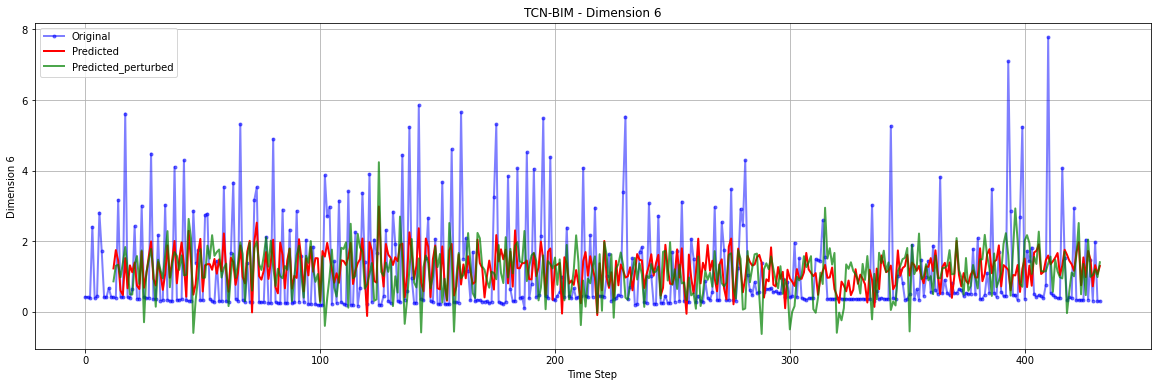

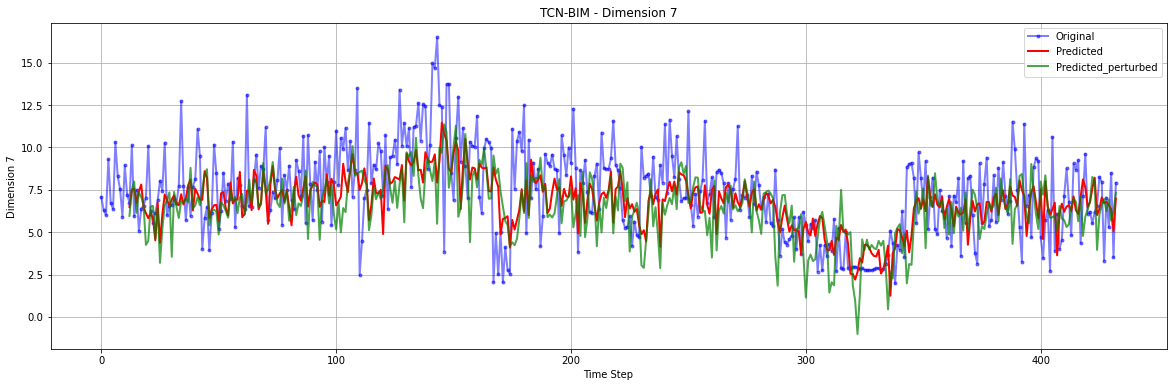

In [12]:
# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs[:, -1, :, :], Y.unsqueeze(2))
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data
# Perform BIM attack
perturbed_data = bim(x_test, y_test, tcn_model, epsilon=0.2, alpha=0.002, I=200)
# Generate predictions from the perturbed data
perturbed_x = perturbed_data.float()
perturbed_predicted = tcn_model(perturbed_x).detach().numpy()
perturbed_predicted = perturbed_predicted[:, -1, :, :]
# Plot the original, predicted, and perturbed data
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'TCN-BIM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted).squeeze() - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted).squeeze() - y_test),dim=0)
print('Metrics for BIM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

Metrics for BIM Prediction
Dimension 1:
MSE: 0.1677
MAE: 0.3321

Dimension 2:
MSE: 0.0011
MAE: 0.0253

Dimension 3:
MSE: 7.0892
MAE: 1.9445

Dimension 4:
MSE: 2.7898
MAE: 1.3730

Dimension 5:
MSE: 1.3346
MAE: 0.8765

Dimension 6:
MSE: 2.2665
MAE: 1.1508

Dimension 7:
MSE: 8.8343
MAE: 2.4366

